In [1]:
# !pip install gdown  # чтобы скачать данные с гугл диска

from IPython.display import clear_output
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy.random as npr
import pandas as pd
import pyEDM   # реализация CCM
import torchdiffeq
from importlib import reload
import torch

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# LAB 404. Аппроксимация Energy Consumption. 
Есть датасет потребления электричества за какой-то период. Нужно научиться предсказывать этот  временной ряд.

Про датасет: измерения потребления электричества берутся каждый час. К этой информации добавляется информация о температуре на улице в этот момент. 

Что делаю: Будем предсказывать потребление в следующий час  по потреблению в предыдущие 9 часов. Во второй части добавлю данные о температуре. Данные делятся на train и test, для train берется более древняя часть датасета, для теста -- более поздняя. Тестовые данные не попадают в train. 

При подготовке датасетов берутся погружения по 10 элементов из низ 9 отмечаются как тренировочная выборка и последнее значение отмечается как target. Для улучшения тренировки train перемешивается -- это помогает декоррелировать элементы в батче.

В качестве моделей используются `LSTM` и `Neural ODE с LSTM`  в качестве дифференциальной функции. Модели оптимизируются с L2 лоссом, так как нужно научиться предсказывать среднее значение, оптимизатор Adam и тренировка проходит в 50 эпох

Также в Neural ODE введен internal loss. Это подсчет лосса по промежуточным предсказаниям. Обучение показало что это улучшает обучение.

________________________________________________________________________________________________

Подготовка датасета

Не придумал ничего лучше чем вынести все в файл и сделать energy исполняемым при импорте

Index(['Date', 'WeekDay', 'Hour', 'ConsumprionMWtH', 'TemperatureC'], dtype='object')


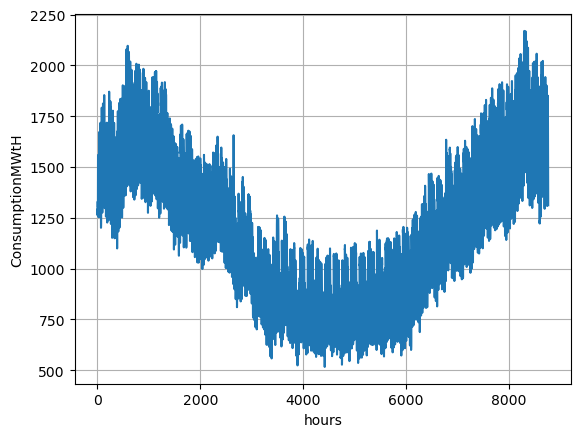

In [2]:
PATH = "./EnergyConsumption.xls"
df = pd.read_excel(PATH)
print(df.columns)
plt.plot(df['ConsumprionMWtH'])
plt.grid()
plt.xlabel('hours')
plt.ylabel('ConsumptionMWtH')
plt.show()

In [6]:
import code_folder.Energy_dataset_preparer as energy
energy = reload(energy)
import code_folder.train as train
import code_folder.Modules as nets
from code_folder.utils import energy_dataloader, energy_dataloader_with_time_axis

(8760, 5)
           WeekDay  ConsumprionMWtH  TemperatureC
count  8760.000000      8760.000000   8760.000000
mean      4.005479      1234.852426      3.038357
std       2.000107       363.852685     14.639117
min       1.000000       516.364014    -30.780681
25%       2.000000       945.324326     -7.599720
50%       4.000000      1216.037262      3.605505
75%       6.000000      1509.718674     15.410224
max       7.000000      2169.305786     34.087811
[21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
(6466, 21)
(6466, 21)
(8760, 5)
           WeekDay  ConsumprionMWtH  TemperatureC
count  8760.000000      8760.000000   8760.000000
mean      4.005479      1234.852426      3.038357
std       2.000107       363.852685     14.639117
min       1.000000       516.364014    -30.780681
25%       2.000000       945.324326     -7.599720
50%       4.000000      1216.037262      3.605505
75%       6.000000      1509.718674     15.410224
max       7.000000      2169.305

Тренировка LSTM модуля

графики показывают: 
    
    1. первый столбец -- лоссы на батчах и лоссы за эпоху на тренировке

    2. второй столбец -- лоссы на батчах и лоссы за эпоху на тесте

    3. нормы градиентов. Были нужны потому что одна из моделей не тренировалась


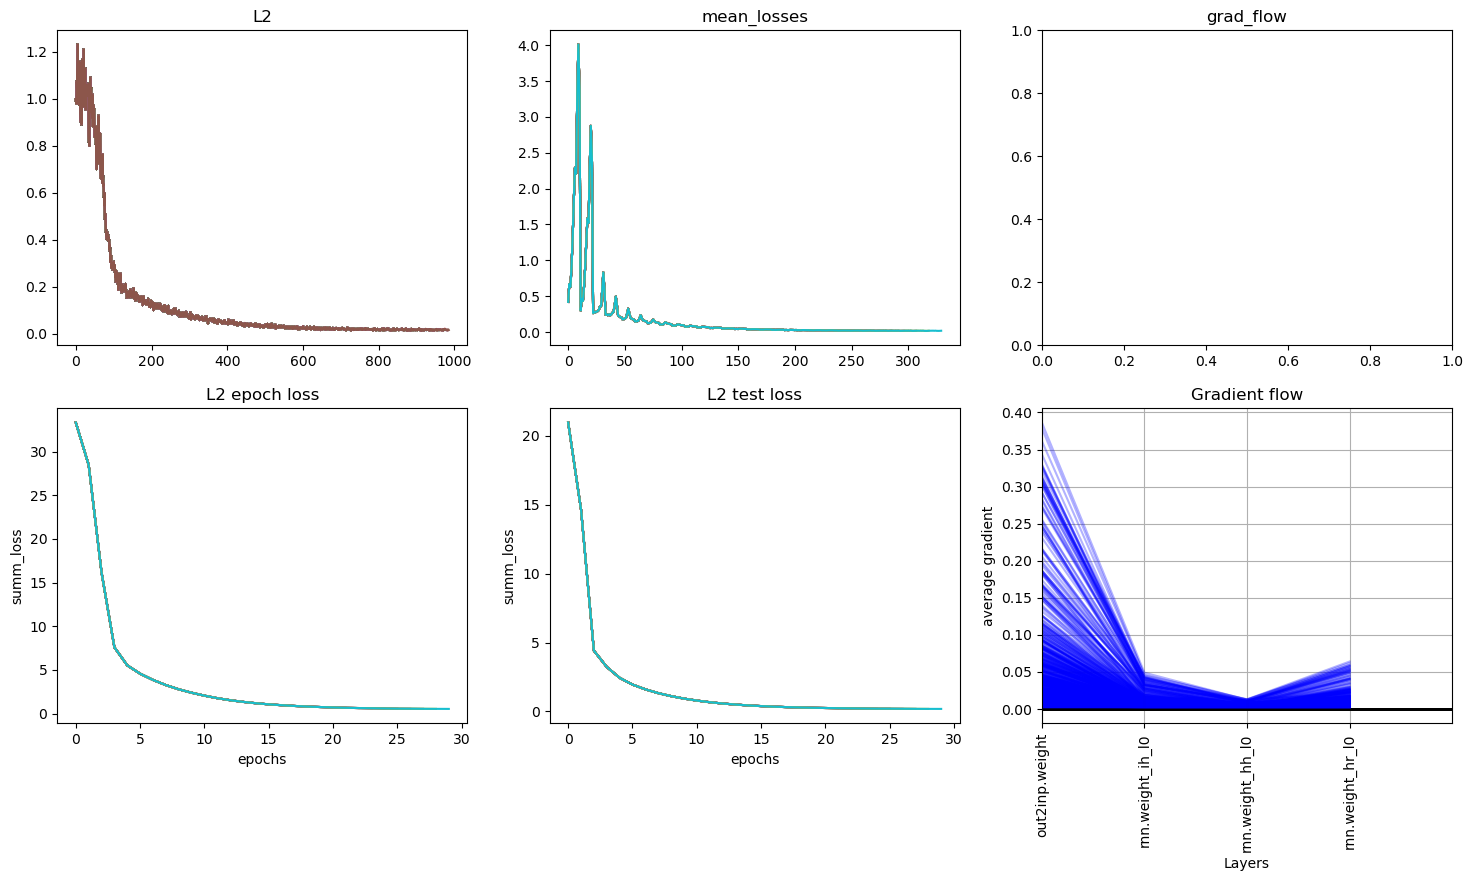

KeyboardInterrupt: 

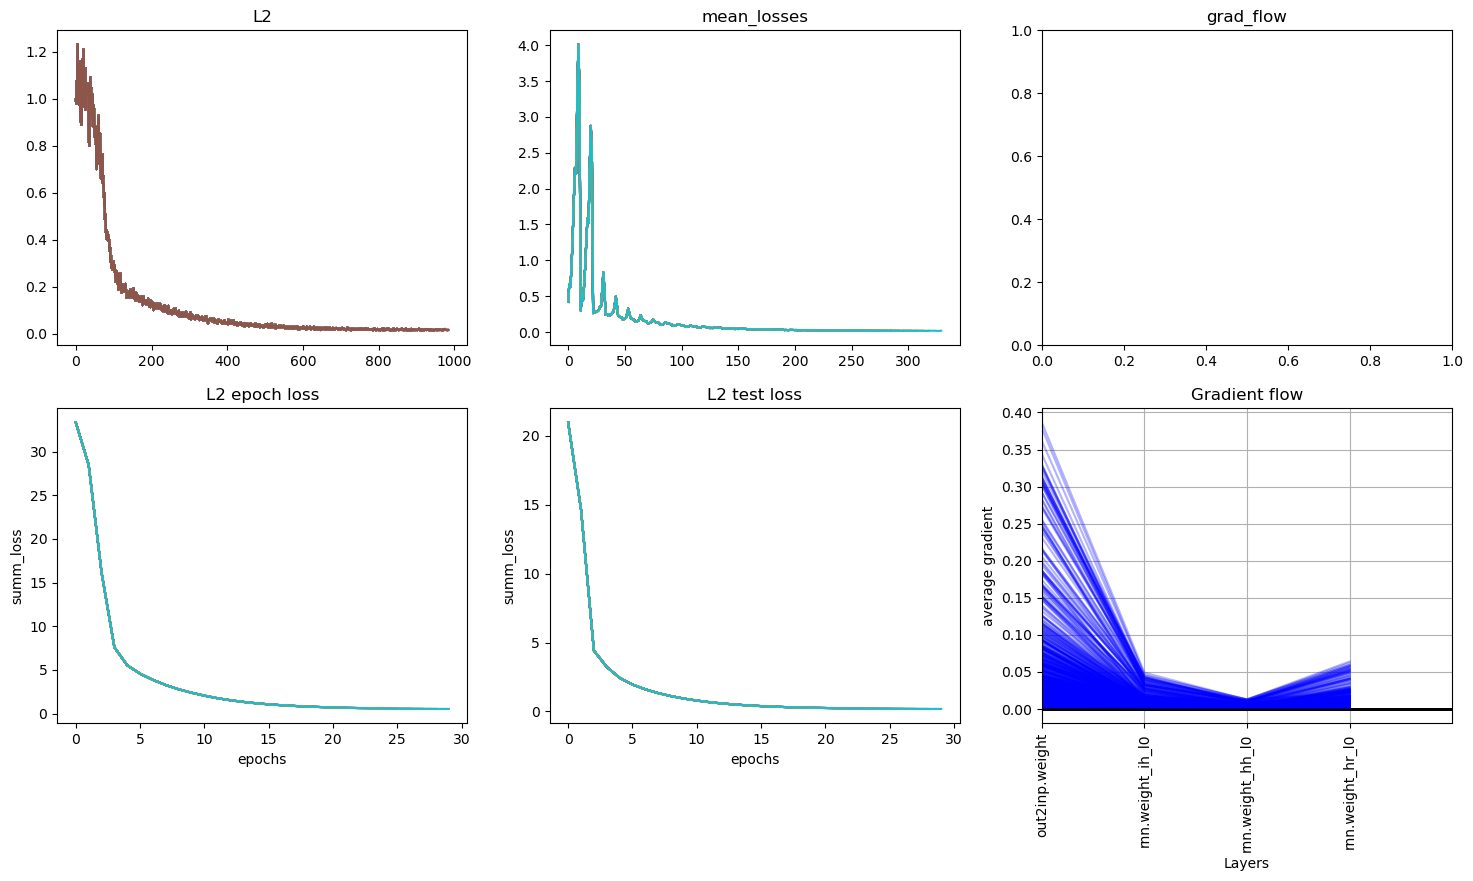

In [7]:
from code_folder.LSTM import LSTM
hidden_dim = 8
epochs = 50
LSTM_net = LSTM( input_dim = 1, hidden_dim= hidden_dim)
optim = torch.optim.Adam(LSTM_net.parameters(),)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=35, gamma=0.8)
    
train_data = energy_dataloader(energy.tr_dataloader, epochs, 10)
test_data = energy_dataloader(energy.tst_dataloader, epochs, 10)

net = train.train_with_epoch(LSTM_net, train_data , test_data, epochs, optim=optim)

Тренировка ode_on_lstm

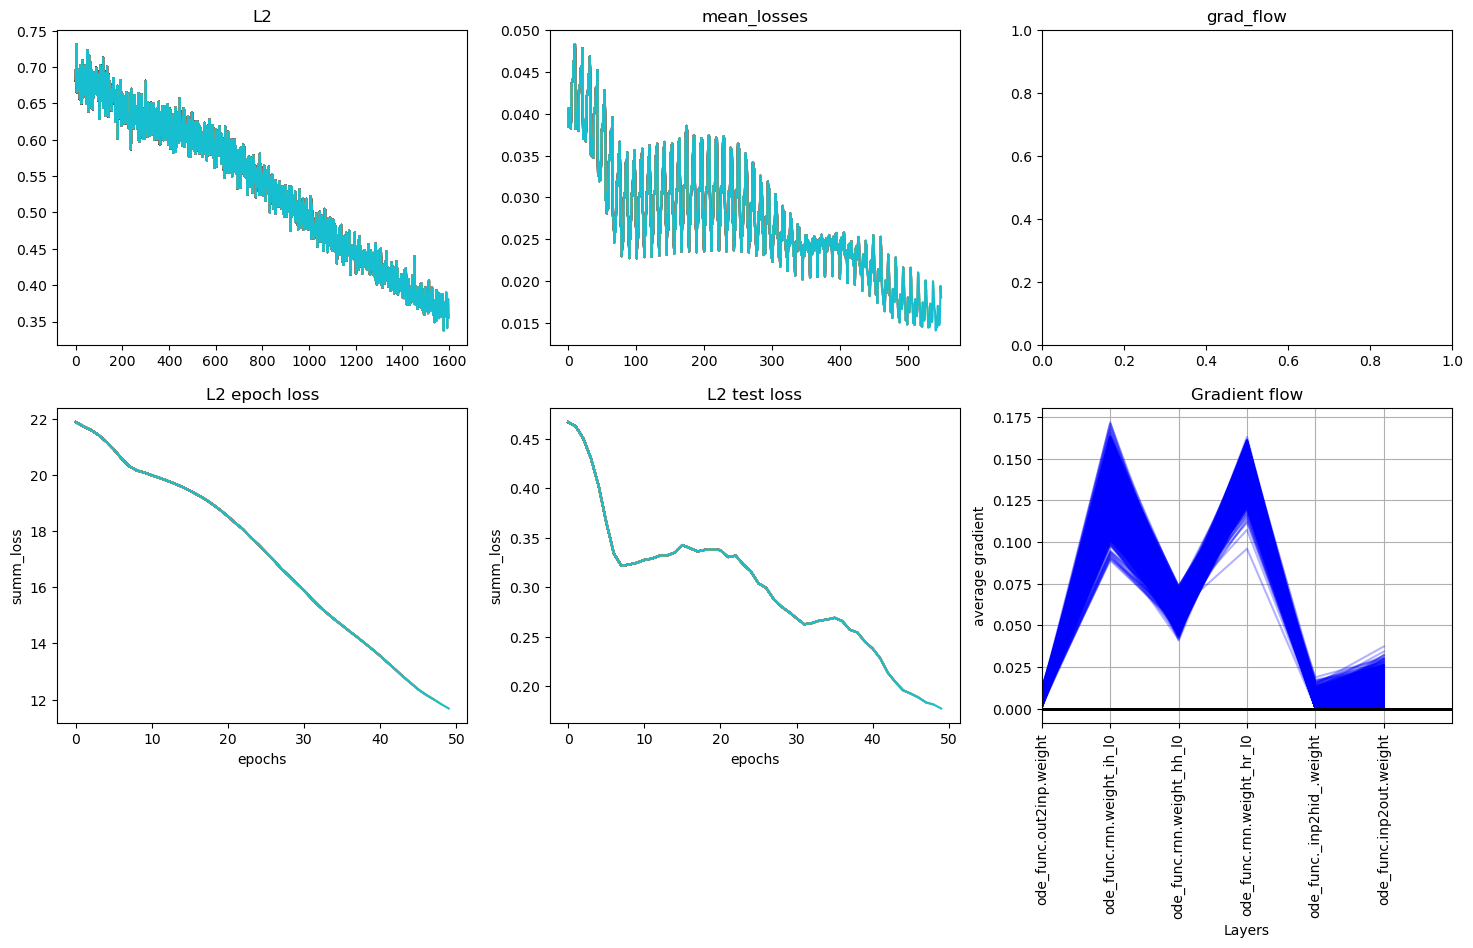

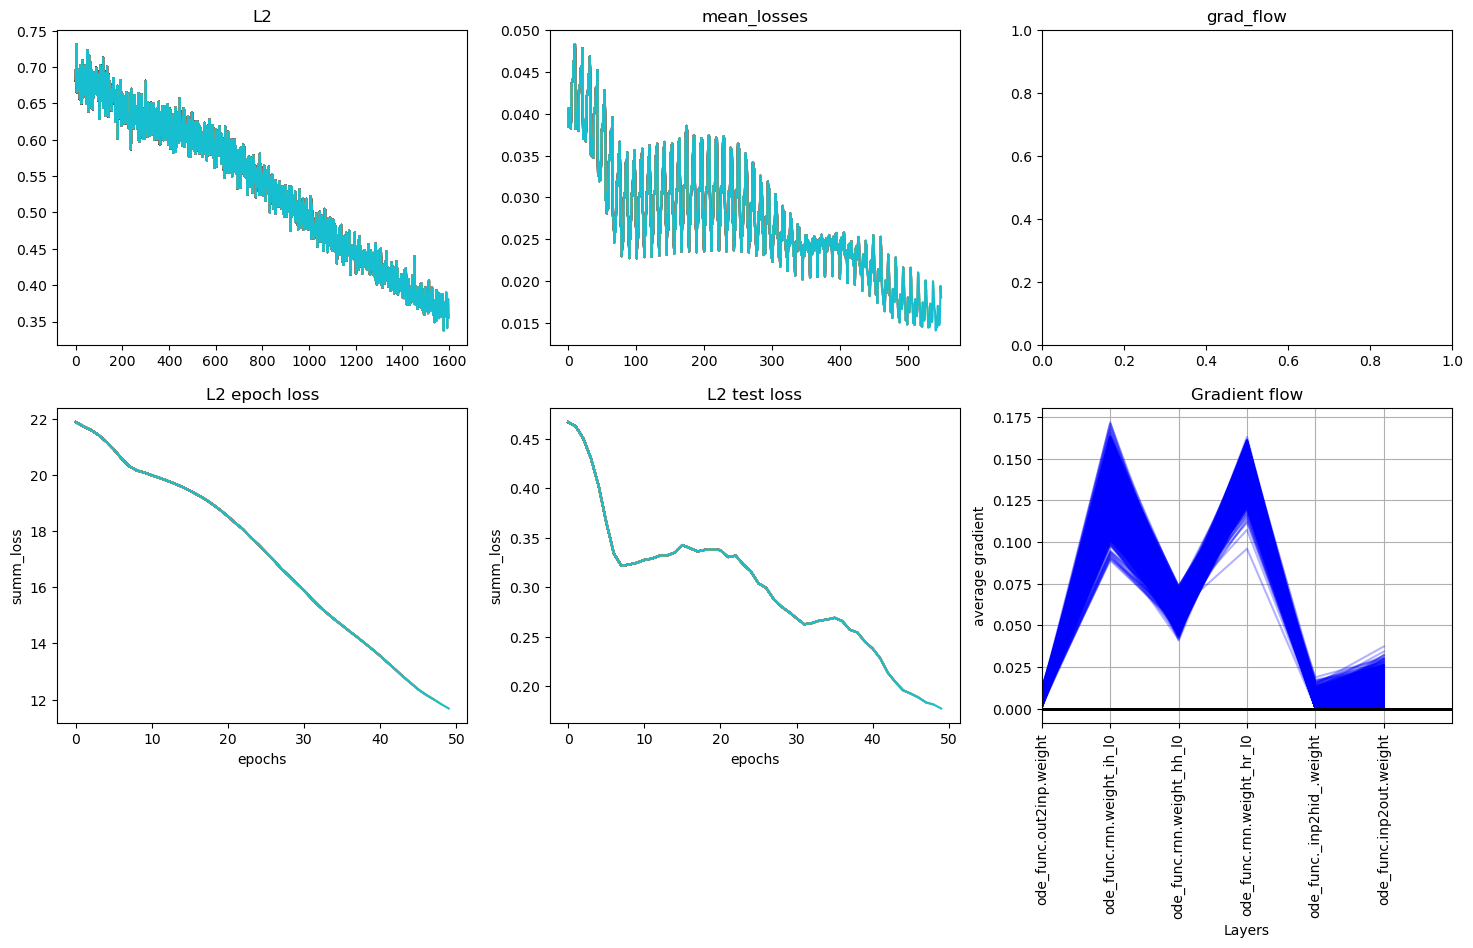

In [8]:
hidden_dim = 6 # 8
epochs = 50
NODE_net = nets.ode_on_lstm( input_dim = 1, hidden_dim= hidden_dim, internal_loss_dim=5)
optim = torch.optim.Adam(NODE_net.parameters(), lr = 1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=35, gamma=0.8)

for p in NODE_net.ode_func.rnn.parameters():
    p.register_hook(lambda grad: grad / torch.norm(grad))
    
train_data = energy_dataloader(energy.tr_dataloader, epochs, 10)
test_data = energy_dataloader(energy.tst_dataloader, epochs, 10)

net = train.train_with_epoch(NODE_net, train_data , test_data, epochs, optim= optim)

## проверка качества

Посмотрим,какие результаты выдают модели на тестовой выборке. Для этого используем RMSE, MAE, R2  метрики

И также отрисуем предсказания моделей для сравнения

Можно сделать модель меньше и получить скоры не хуже:

In [9]:
from code_folder.utils import compute_metrics
# compute_metrics =re
test_data = next(energy_dataloader(energy.tst_dataloader, 1, scale_factor = 10))
dct_lstm, y_lstm, y_true_lstm= compute_metrics(LSTM_net, test_data, energy)

test_data = next(energy_dataloader(energy.tst_dataloader, 1, scale_factor = 10))
dct_node, y_node, y_true_node= compute_metrics(NODE_net, test_data, energy)
pd.DataFrame([dct_node, dct_lstm], index = ["NODE", "LSTM"])

,RMSE,MAE,R2,#parameters
NODE,44.586594,35.450272,0.974607,250
LSTM,45.428246,34.271519,0.973639,384


если сделать модель больше, то NODE показывает результаты лучше

In [158]:
from code_folder.utils import compute_metrics
# compute_metrics =re
test_data = next(energy_dataloader(energy.tst_dataloader, 1, scale_factor = 10))
dct_lstm, y_lstm, y_true_lstm= compute_metrics(LSTM_net, test_data, energy)

test_data = next(energy_dataloader(energy.tst_dataloader, 1, scale_factor = 10))
dct_node, y_node, y_true_node= compute_metrics(NODE_net, test_data, energy)
pd.DataFrame([dct_node, dct_lstm], index = ["NODE", "LSTM"])

,RMSE,MAE,R2,#parameters
NODE,39.593307,29.842447,0.979982,414
LSTM,45.152130,34.349411,0.973966,384


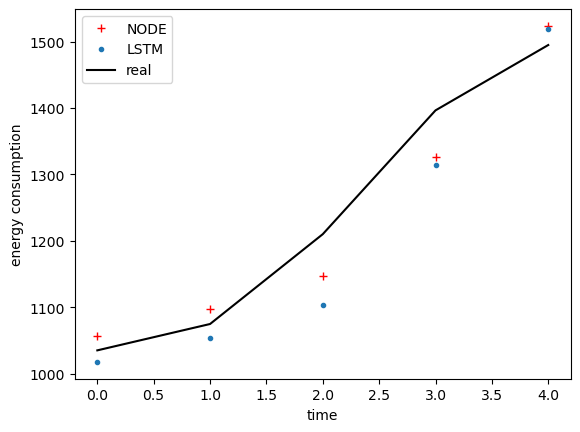

In [177]:
fr = 525
to = 530
plt.plot(y_node[fr:to], '+', label = 'NODE', color = 'red')
plt.plot(y_lstm[fr:to], '.', label = "LSTM")

plt.plot(y_true_node[fr:to], color = 'black', label= "real")

plt.xlabel("time")
plt.ylabel("energy consumption")
plt.legend()
plt.show()


## аппроксимация с данными о температуре
Теперь добавляем данные о температуре. Они сильно коррелируют с целевым значением, так что знание температуры может помочь предсказывать погоду

In [242]:
import code_folder.Energy_dataset_prepare_with_temperature as energy
energy = reload(energy)

(8760, 5)
           WeekDay  ConsumprionMWtH  TemperatureC
count  8760.000000      8760.000000   8760.000000
mean      4.005479      1234.852426      3.038357
std       2.000107       363.852685     14.639117
min       1.000000       516.364014    -30.780681
25%       2.000000       945.324326     -7.599720
50%       4.000000      1216.037262      3.605505
75%       6.000000      1509.718674     15.410224
max       7.000000      2169.305786     34.087811
Train size = 6475
Test size = 2276
(6475, 9, 2)
(8760, 5)
           WeekDay  ConsumprionMWtH  TemperatureC
count  8760.000000      8760.000000   8760.000000
mean      4.005479      1234.852426      3.038357
std       2.000107       363.852685     14.639117
min       1.000000       516.364014    -30.780681
25%       2.000000       945.324326     -7.599720
50%       4.000000      1216.037262      3.605505
75%       6.000000      1509.718674     15.410224
max       7.000000      2169.305786     34.087811
Train size = 6475
Test size = 22

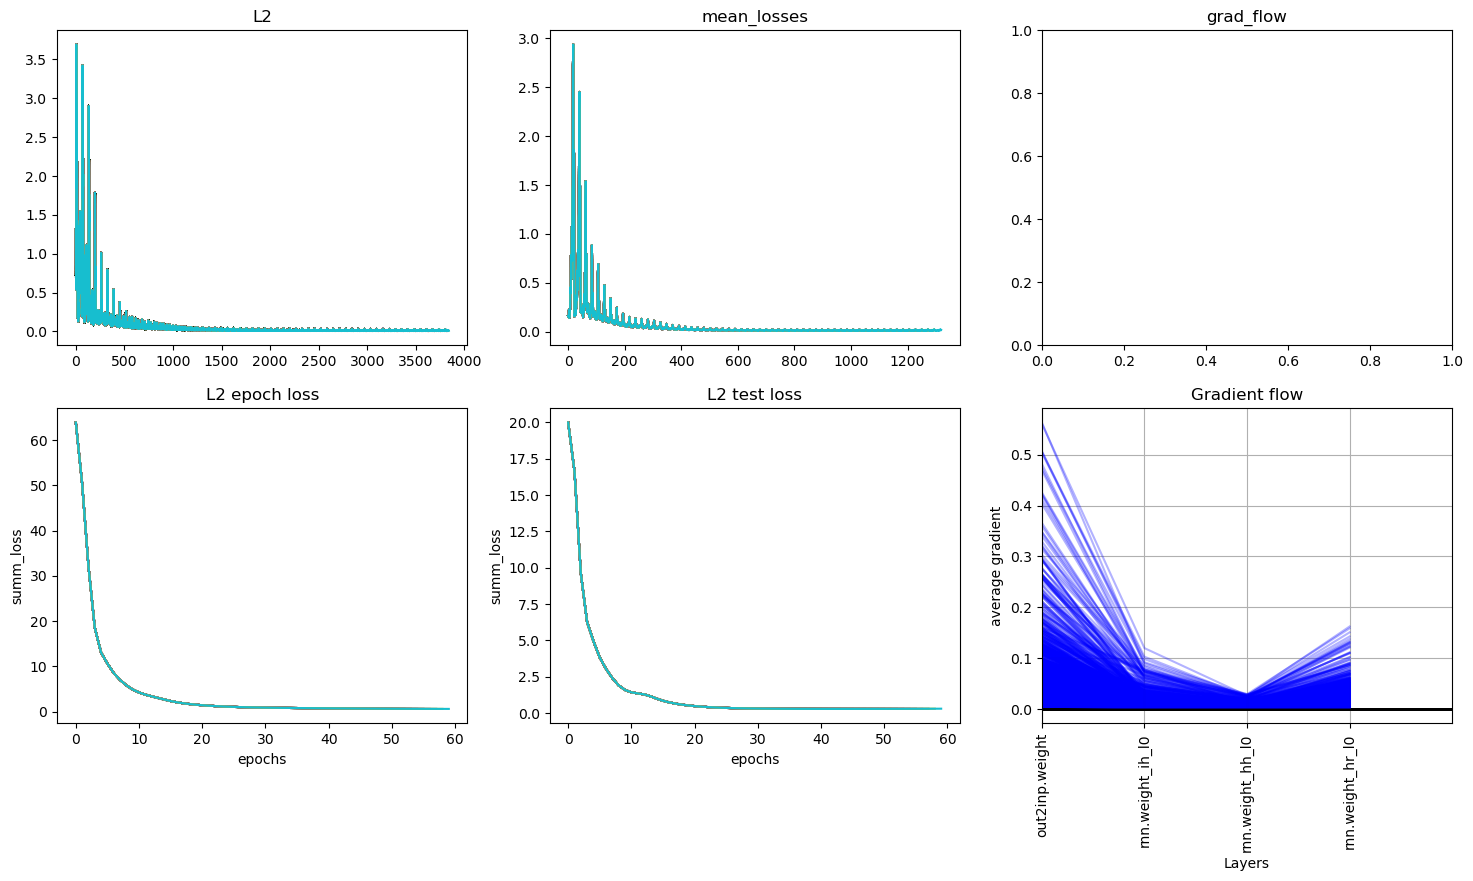

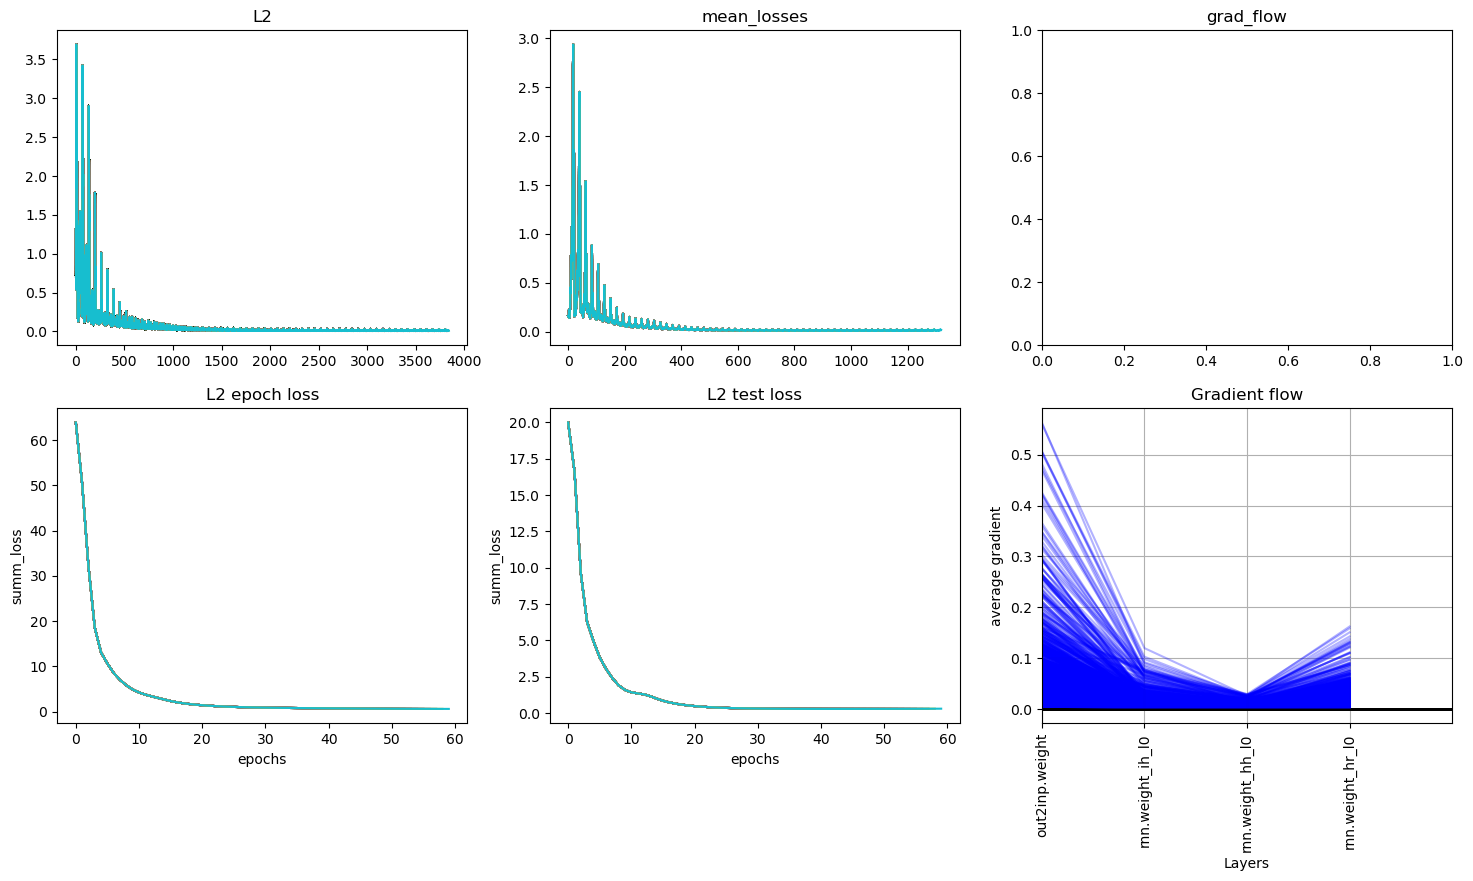

In [251]:
from code_folder.LSTM import LSTM
hidden_dim = 8
epochs = 60
LSTM_net = LSTM( input_dim = 2, hidden_dim= hidden_dim)
optim = torch.optim.Adam(LSTM_net.parameters(),)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=35, gamma=0.8)
    

train_data = energy_dataloader_with_time_axis(energy.tr_dataloader, epochs, 10)
test_data = energy_dataloader_with_time_axis(energy.tst_dataloader, epochs, 10)

LSTM_net = train.train_with_epoch(LSTM_net, train_data , test_data, epochs, optim=optim)

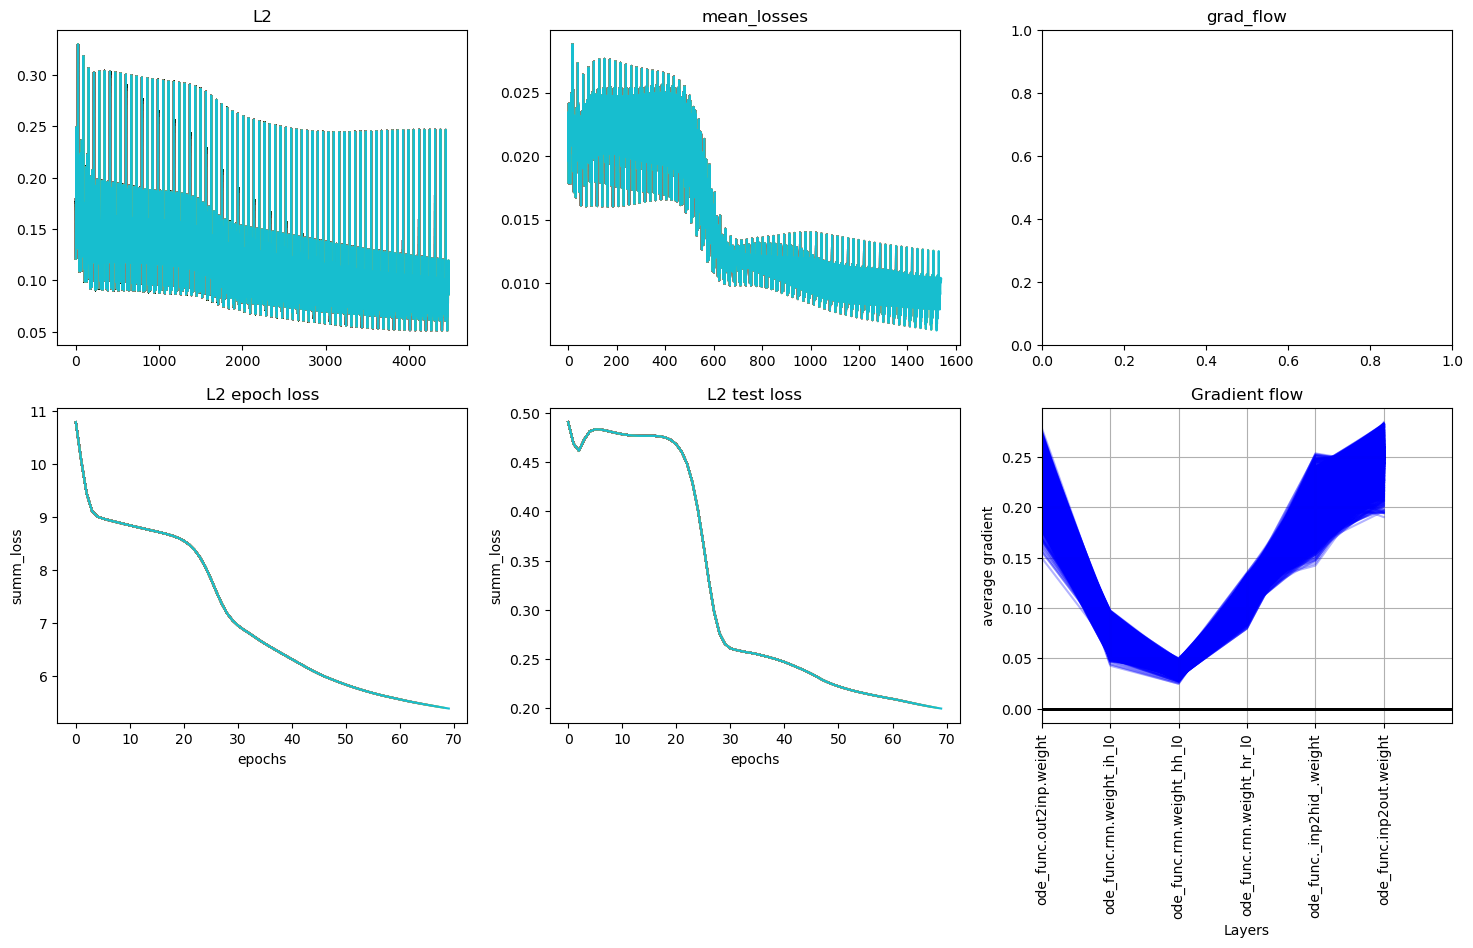

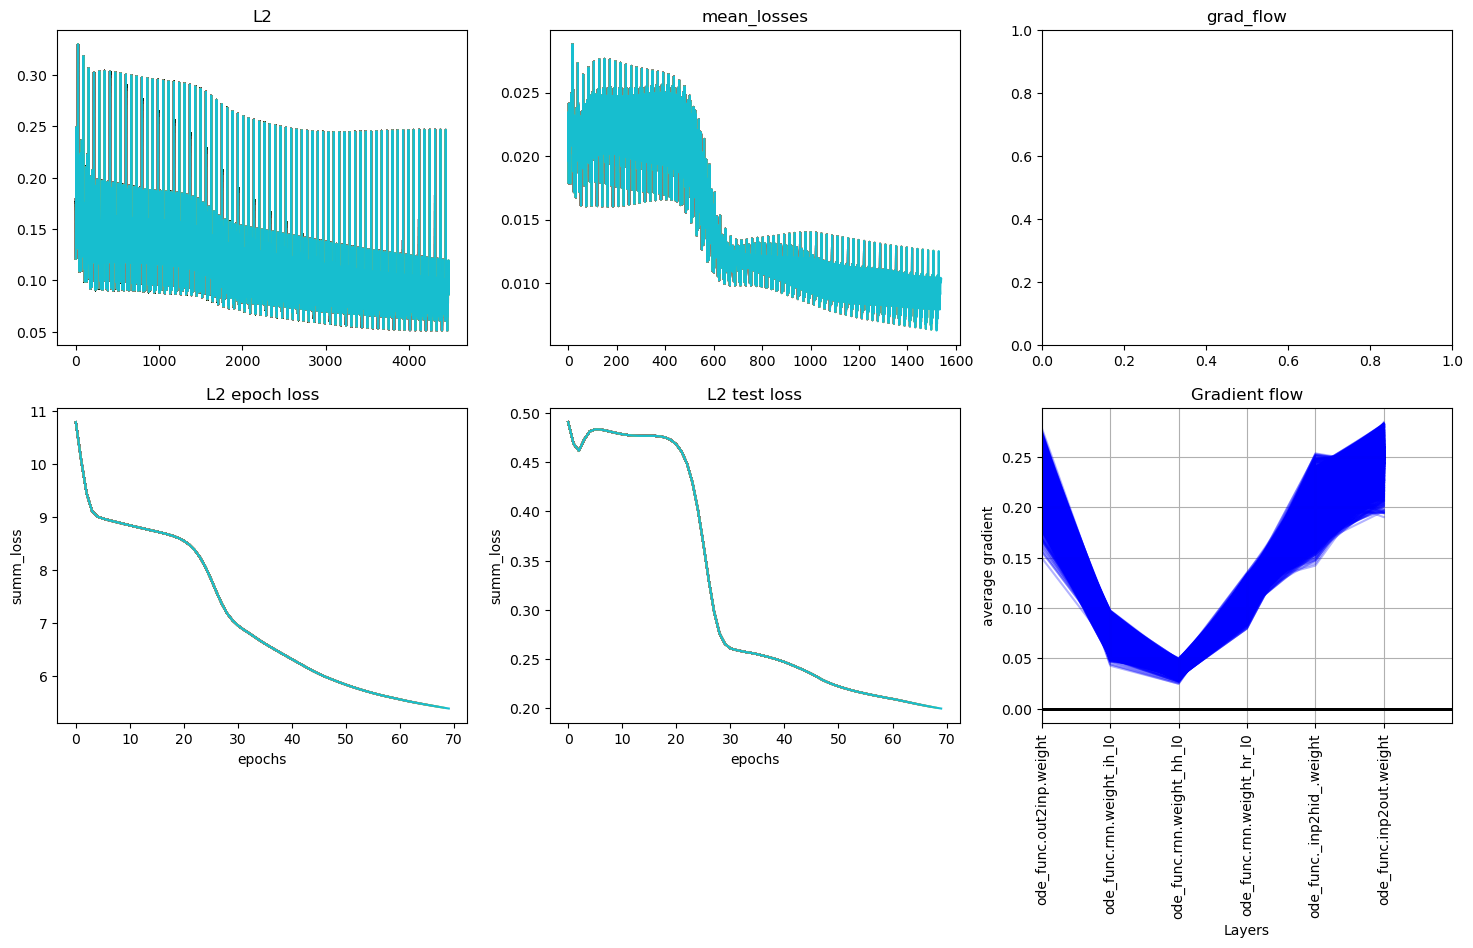

In [249]:
hidden_dim = 7
epochs = 70
Energy_net = nets.ode_on_lstm(2,  hidden_dim, internal_loss_dim= 5)

optim = torch.optim.Adam(Energy_net.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=35, gamma=0.8)
for p in Energy_net.ode_func.parameters():
    p.register_hook(lambda grad: grad / torch.norm(grad))
    

train_data = energy_dataloader_with_time_axis(energy.tr_dataloader, epochs, 10)
test_data = energy_dataloader_with_time_axis(energy.tst_dataloader, epochs, 10)


net = train.train_with_epoch(Energy_net, train_data , test_data, epochs, optim = optim, save_best = False)


In [256]:

from code_folder.utils import compute_metrics
# compute_metrics =re
test_data = next(energy_dataloader_with_time_axis(energy.tst_dataloader, 1, 10))
dct_lstm, y_lstm, y_true_lstm= compute_metrics(LSTM_net, test_data, energy)

test_data = next(energy_dataloader_with_time_axis(energy.tst_dataloader, 1, 10))
dct_node, y_node, y_true_node= compute_metrics(Energy_net, test_data, energy)
pd.DataFrame([dct_node, dct_lstm], index = ["NODE", "LSTM"])



(2200, 2)
(2200, 2)


,RMSE,MAE,R2,#parameters
NODE,45.334297,33.713684,0.973755,375
LSTM,55.393501,42.819344,0.960816,424


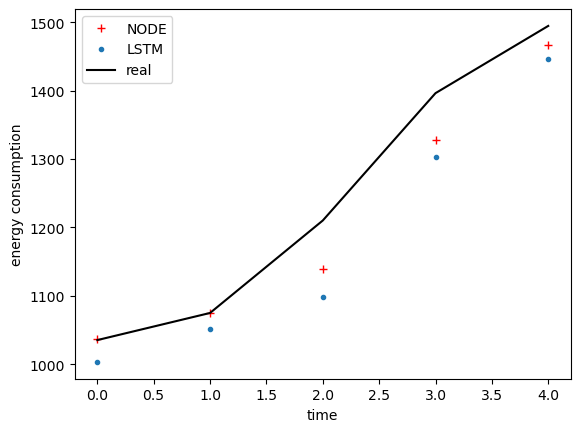

In [257]:
fr = 525
to = 530
plt.plot(y_node[fr:to], '+', label = 'NODE', color = 'red')
plt.plot(y_lstm[fr:to], '.', label = "LSTM")

plt.plot(y_true_node[fr:to], color = 'black', label= "real")

plt.xlabel("time")
plt.ylabel("energy consumption")
plt.legend()
plt.show()
